In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
import pickle

from time import sleep
from tqdm.auto import tqdm
from utils import logger, rule_base_predict, to_yolo

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains
from selenium.webdriver.common.keys import Keys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import numba

START_TS = datetime.now()

2021-05-22 13:53:02,459 -INFO - config:config.py:16 - Module utils.config was loaded
2021-05-22 13:53:02,459 -INFO - common:common.py:561 - Module utils.common is loaded...
2021-05-22 13:53:02,459 -INFO - dataset_builder:dataset_builder.py:244 - dataset package is loaded...
2021-05-22 13:53:03,107 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

In [3]:
selenium.__version__

'3.141.0'

## Parameters

2021-05-22 13:53:03,163 -INFO - dataset_builder:dataset_builder.py:121 - Dataset name: wildberries
2021-05-22 13:53:03,164 -INFO - dataset_builder:dataset_builder.py:130 - Create directories to save the dataset
2021-05-22 13:53:03,165 -INFO - dataset_builder:dataset_builder.py:165 - Creating driver
2021-05-22 13:53:04,243 -INFO - dataset_builder:dataset_builder.py:173 - Chrome web driver is created
2021-05-22 13:53:04,355 -INFO - <ipython-input-4-975af85d63db>:<ipython-input-4-975af85d63db>:11 - getting url: https://www.wildberries.ru/catalog/muzhchinam/odezhda/dzhinsy
2021-05-22 13:53:11,270 -INFO - dataset_builder:dataset_builder.py:176 - save scrinshot: dataset/images/wildberries.png
2021-05-22 13:53:13,886 -INFO - dataset_builder:dataset_builder.py:220 - Collect features using JS script
2021-05-22 13:53:18,059 -INFO - dataset_builder:dataset_builder.py:228 - Save html to dataset/html/wildberries.html
2021-05-22 13:53:18,114 -INFO - dataset_builder:dataset_builder.py:238 - Save parq

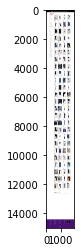

In [4]:
SITE_URL = 'https://www.wildberries.ru/catalog/muzhchinam/odezhda/dzhinsy'
DATASET_NAME = 'wildberries'
class JDIDatasetBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        driver.set_window_size(width=1920, height=15000)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        #maximize_window(driver=driver, extend_pix=0)
        

with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))



In [5]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')

In [6]:
df.head()

attributes  displayed  \
0  {'accept': None, 'action': None, 'alt': None, ...       True   
1  {'accept': None, 'action': None, 'alt': None, ...      False   
2  {'accept': None, 'action': None, 'alt': None, ...      False   
3  {'accept': None, 'action': None, 'alt': None, ...      False   
4  {'accept': None, 'action': None, 'alt': None, ...      False   

                     element_id   height onmouseenter onmouseover  \
0  5761362370807938942270359461  15000.0         None        None   
1  4587122034807938940012731920      0.0         None        None   
2  4624677912807938948435859241      0.0         None        None   
3  1997487036807938942983208487      0.0         None        None   
4  2820207138807938946587280839      0.0         None        None   

                      parent_id  \
0                          None   
1  5761362370807938942270359461   
2  4587122034807938940012731920   
3  4587122034807938940012731920   
4  4587122034807938940012731920   

                                               style tag_name  \
0  [align-content, align-items, align-self, align...     HTML   
1  [align-content, align-items, align-self, align...     HEAD   
2  [align-content, align-items, align-self, align...     META   
3  [align-content, align-items, align-self, align...     META   
4  [align-content, align-items, align-self, align...     BASE   

                                                text   width    x    y  
0  Ru \nЯрославль\nБесплатная доставка\nПродавайт...  1920.0  0.0  0.0  
1  \n    \n    \n    \n    \n    \n    \n    \n  ...     0.0  0.0  0.0  
2                                                        0.0  0.0  0.0  
3                                                        0.0  0.0  0.0  
4                                                        0.0  0.0  0.0

In [7]:
controls_df = rule_base_predict(df)
controls_df

2021-05-22 13:53:20,598 -INFO - common:common.py:463 - Num radio buttons found: 27
2021-05-22 13:53:20,603 -INFO - common:common.py:467 - Num radio2 buttons found: 4
2021-05-22 13:53:20,609 -INFO - common:common.py:471 - Num checkboxes found: 0
2021-05-22 13:53:20,618 -INFO - common:common.py:477 - Num comboboxes/dropdowns found: 0
2021-05-22 13:53:20,625 -INFO - common:common.py:488 - Num textfields found: 3
2021-05-22 13:53:20,630 -INFO - common:common.py:493 - Num texfields for numbers found: 0
2021-05-22 13:53:20,635 -INFO - common:common.py:498 - Num ranges found: 0
2021-05-22 13:53:20,640 -INFO - common:common.py:503 - Num ordinary text inputs found: 0
2021-05-22 13:53:20,643 -INFO - common:common.py:506 - Num buttons found: 115
2021-05-22 13:53:20,648 -INFO - common:common.py:510 - Num links found: 276


element_id           x        y       width  height  \
49    2617668858807938949225249959    0.000000      0.0    0.000000     0.0   
56    8407757062807938946358635901    0.000000      0.0    0.000000     0.0   
63    2691451726807938945036418046    0.000000      0.0    0.000000     0.0   
70    6997347567807938948132557857    0.000000      0.0    0.000000     0.0   
77    0856102322807938948931516252    0.000000      0.0    0.000000     0.0   
...                            ...         ...      ...         ...     ...   
5633  7495196665807939020055217017  877.359375  14883.0  165.265625    20.0   
5639  0106003891807939024661861410    0.000000      0.0    0.000000     0.0   
5643  6395074105807939027685979152    0.000000      0.0    0.000000     0.0   
5646  4240233231807939026862827806    0.000000      0.0    0.000000     0.0   
5648  7413831819807939021909887386    0.000000      0.0    0.000000     0.0   

      label  
49        7  
56        7  
63        7  
70        7  
77        7  
...     ...  
5633      1  
5639      1  
5643      1  
5646      1  
5648      1  

[425 rows x 6 columns]

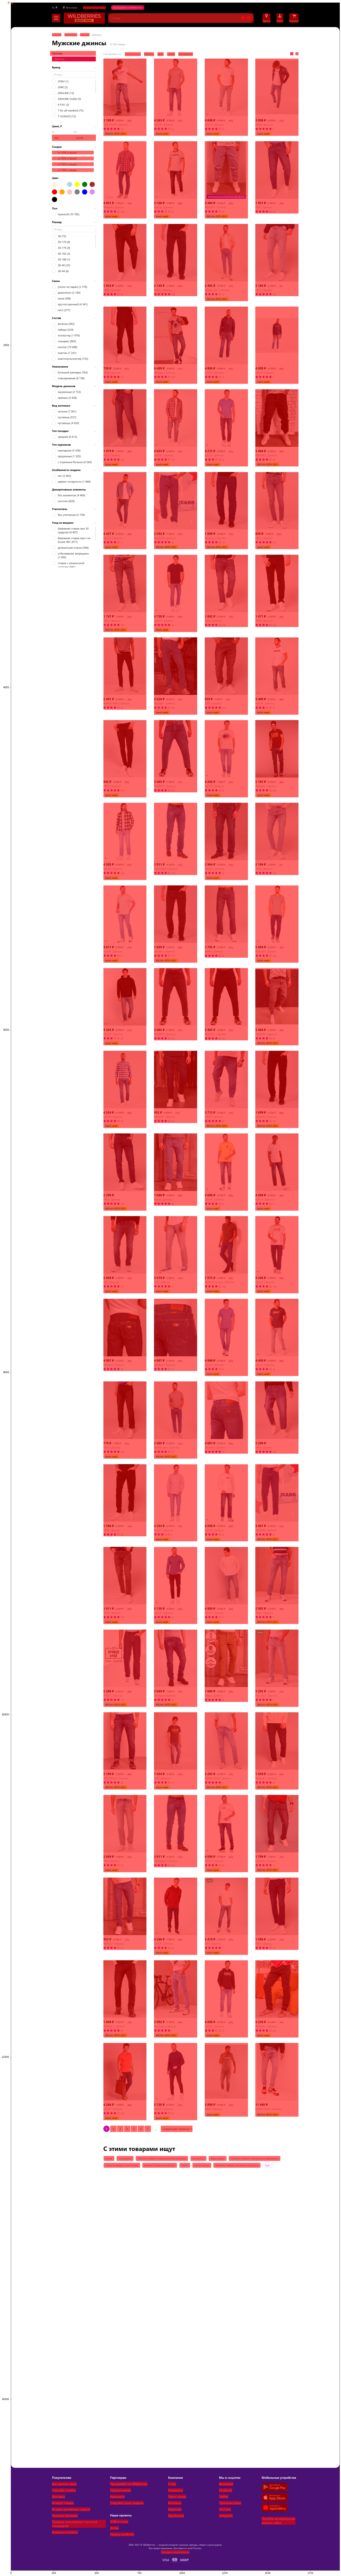

In [8]:
plt.figure(figsize=(30,200))
img = plt.imread(f'dataset/images/{DATASET_NAME}.png')
plt.imshow(img)
axes = plt.gca()

COLUMNS = ['element_id', 'x', 'y', 'width', 'height']

def display_controls(df: pd.DataFrame, axes=axes, color='red'):
    for r in df.iterrows():
        idx, ( uuid, x, y, w, h) = r

        if w == 0:
            w += 20 
            x -= 8
        if h == 0:
            h += 20 
            y -= 12

        patch = patches.Rectangle((x,y), w, h, linewidth=2, alpha = .6, facecolor = color)
        axes.add_patch(patch)
        # print(idx, x, y, w, h)
    
display_controls(controls_df[COLUMNS])


In [9]:
img.shape

(15000, 1920, 4)

In [10]:
# def to_yolo(label:int, x:int, y:int, w:int, h:int, img_width:int, img_height:int):
#     if x<=0 and y<=0 and w==0 and h == 0:
#         return [label, 0,0,0,0]
#     if w == 0:
#         w += 20
#         x -= 6
#     if h == 0:
#         h += 20
#         y -= 10
    
#     return [label, 
#             round((x + w / 2) / img_width, 6), 
#             round((y + h / 2) / img_height, 6),
#             round(w / img_width, 6), 
#             round(h / img_height, 6)]
        
    
display(to_yolo(**{'label': 5, 'x': 0, 'y': 0, 'w': 0, 'h': 0, 'img_width': img.shape[1], 'img_height': img.shape[0]}))
display(to_yolo(**{'label': 5, 'x': 100, 'y': 100, 'w': 0, 'h': 0, 'img_width': img.shape[1], 'img_height': img.shape[0]}))


[5, 0, 0, 0, 0]

[5, 0.054167, 0.006667, 0.010417, 0.001333]

In [11]:
controls_df['yolo'] = controls_df.apply(
    lambda r: to_yolo(label=r['label'],  
                      x=r['x'], 
                      y=r['y'], 
                      w=r['width'], 
                      h=r['height'], 
                      img_width=img.shape[1], 
                      img_height=img.shape[0]), 
    axis=1
)

In [12]:
controls_df

element_id           x        y       width  height  \
49    2617668858807938949225249959    0.000000      0.0    0.000000     0.0   
56    8407757062807938946358635901    0.000000      0.0    0.000000     0.0   
63    2691451726807938945036418046    0.000000      0.0    0.000000     0.0   
70    6997347567807938948132557857    0.000000      0.0    0.000000     0.0   
77    0856102322807938948931516252    0.000000      0.0    0.000000     0.0   
...                            ...         ...      ...         ...     ...   
5633  7495196665807939020055217017  877.359375  14883.0  165.265625    20.0   
5639  0106003891807939024661861410    0.000000      0.0    0.000000     0.0   
5643  6395074105807939027685979152    0.000000      0.0    0.000000     0.0   
5646  4240233231807939026862827806    0.000000      0.0    0.000000     0.0   
5648  7413831819807939021909887386    0.000000      0.0    0.000000     0.0   

      label                                         yolo  
49        7                              [7, 0, 0, 0, 0]  
56        7                              [7, 0, 0, 0, 0]  
63        7                              [7, 0, 0, 0, 0]  
70        7                              [7, 0, 0, 0, 0]  
77        7                              [7, 0, 0, 0, 0]  
...     ...                                          ...  
5633      1  [1, 0.499996, 0.992867, 0.086076, 0.001333]  
5639      1                              [1, 0, 0, 0, 0]  
5643      1                              [1, 0, 0, 0, 0]  
5646      1                              [1, 0, 0, 0, 0]  
5648      1                              [1, 0, 0, 0, 0]  

[425 rows x 7 columns]

In [13]:
labeled_df = pd.DataFrame(controls_df.yolo.values.tolist(), columns=['label', 'x', 'y', 'width', 'height'])
display(labeled_df)
labeled_df.to_csv(f'dataset/annotations/{DATASET_NAME}.txt', header=False, sep=' ', index=False)

label         x         y     width    height
0        7  0.000000  0.000000  0.000000  0.000000
1        7  0.000000  0.000000  0.000000  0.000000
2        7  0.000000  0.000000  0.000000  0.000000
3        7  0.000000  0.000000  0.000000  0.000000
4        7  0.000000  0.000000  0.000000  0.000000
..     ...       ...       ...       ...       ...
420      1  0.499996  0.992867  0.086076  0.001333
421      1  0.000000  0.000000  0.000000  0.000000
422      1  0.000000  0.000000  0.000000  0.000000
423      1  0.000000  0.000000  0.000000  0.000000
424      1  0.000000  0.000000  0.000000  0.000000

[425 rows x 5 columns]